In [1]:
import os
import nibabel as nib
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import numpy as np
from LazyLuna.CATCH_utils import *
from LazyLuna.Mini_LL import *
from catch_converter.parse_contours import parse_cvi42ws

import pydicom
from pydicom.dataset import Dataset
import pydicom._storage_sopclass_uids

In [2]:
# from nifti path
base_nii = '/Users/dietrichhadler/Desktop/Daten/emidec-dataset-1.0.1'

# to dcm and LL anno path
gold_path = '/Users/dietrichhadler/Desktop/Daten/Emidec/Gold'
imgs_path = '/Users/dietrichhadler/Desktop/Daten/Emidec/Imgs'

In [3]:
folders = [f for f in os.listdir(base_nii) if os.path.isdir(os.path.join(base_nii, f))]
for f in folders:
    a_nii_p = os.path.join(base_nii, f, 'Contours')
    i_nii_p = os.path.join(base_nii, f, 'Images')
print(len(folders))

50


In [4]:
###################
# Transform Annos #
###################
def emidec_to_anno_dict(mask, img_size, pixel_size):
    # 1: endo # 2: healthy myo # 3: scar # 4: no reflow
    endo_cont     = to_polygon((mask==1).astype(np.int16))
    myo_cont      = to_polygon((mask>=2).astype(np.int16))
    scar_cont     = to_polygon((mask==3).astype(np.int16))
    noreflow_cont = to_polygon((mask==4).astype(np.int16))
    anno_dict = dict()
    if not endo_cont.is_empty:     anno_dict['lv_endo']  = {'cont': endo_cont}
    if not myo_cont.is_empty :     anno_dict['lv_myo']   = {'cont': myo_cont}
    if not scar_cont.is_empty:     anno_dict['scar']  = {'cont': scar_cont}
    if not noreflow_cont.is_empty: anno_dict['noreflow'] = {'cont': noreflow_cont}
    anno_dict['info'] = {'imageSize': img_size, 'pixelSize': pixel_size}
    return anno_dict

def emidec_transform_to_ll_annos(nii_annos, bpath, studyiuid, sops):
    contdir = os.path.join(bpath, studyiuid) 
    if not os.path.exists(contdir): os.mkdir(contdir)
    h , w, nr_slices = nii_annos.shape
    ph, pw, slice_th = nii_annos.header['pixdim'][1:4]
    mask_data = nii_annos.get_fdata().astype(np.int32)
    ll_annos = []
    for d in range(nr_slices):
        ll_annos.append(emidec_to_anno_dict(mask_data[:,:,d], [h,w], [ph,pw]))
        with open(os.path.join(contdir, sops[d]+'.pickle'), 'wb') as f:
            pickle.dump(ll_annos[-1], f, pickle.HIGHEST_PROTOCOL)
    return ll_annos        

In [5]:
def nifti_to_dcm(nii_imgs, bpath, casename):
    if not os.path.exists(os.path.join(bpath, casename)):
        os.mkdir(os.path.join(bpath, casename))
    h, w, nr_slices  = nii_imgs.header['dim'][1:4]
    ph, pw, pdepth = nii_imgs.header['pixdim'][1:4]
    imgs = nii_imgs.get_fdata()
    sops = []
    studyinstanceuid = pydicom.uid.generate_uid()
    for d in range(nr_slices):
        img = imgs[:,:,d]
        img = img.astype(np.uint16)
        meta = pydicom.Dataset()
        meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
        meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
        meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
        ds = Dataset()
        ds.file_meta = meta
        ds.SOPInstanceUID = pydicom.uid.generate_uid()
        ds.is_little_endian = True
        ds.is_implicit_VR = False
        ds.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
        ds.PatientName = 'PatientX'
        ds.PatientID = "123456"
        ds.Modality = "MR"
        ds.SeriesInstanceUID = pydicom.uid.generate_uid()
        ds.StudyInstanceUID  = studyinstanceuid
        ds.FrameOfReferenceUID = pydicom.uid.generate_uid()
        ds.SeriesDescription = "sax lge"
        ds.SliceLocation  = d*pdepth
        ds.SliceThickness = str(pdepth)
        ds.SpacingBetweenSlices = str(pdepth)
        ds.PixelSpacing = str(ph)+'\\'+str(pw)
        ds.SeriesNumber = 0
        ds.BitsStored = 16
        ds.BitsAllocated = 16
        ds.SamplesPerPixel = 1
        ds.HighBit = 15
        ds.ImagesInAcquisition = "1"
        ds.Rows    = h
        ds.Columns = w
        ds.InstanceNumber = 0
        ds.ImagePositionPatient = r"0\0\1"
        ds.ImageOrientationPatient = r"1\0\0\0\-1\0"
        ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"
        ds.RescaleIntercept = "0"
        ds.RescaleSlope     = "1"
        ds.PhotometricInterpretation = "MONOCHROME2"
        ds.PixelRepresentation = 1
        pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
        ds.PixelData = img.tobytes()
        ds.private_block(0x000b, 'Lazy Luna: SAX LGE', create=True)
        filename = os.path.join(bpath, casename, str(d)+'.dcm')
        ds.save_as(filename=filename, write_like_original=False)
        sops.append(ds.SOPInstanceUID)
    return studyinstanceuid, sops

In [6]:
folders = [f for f in os.listdir(base_nii) if os.path.isdir(os.path.join(base_nii, f))]
for f in folders:
    img_path  = os.path.join(base_nii, f, 'Images')
    anno_path = os.path.join(base_nii, f, 'Contours')
    nii_imgs  = nib.load(os.path.join(img_path,  f+'.nii.gz'))
    nii_annos = nib.load(os.path.join(anno_path, f+'.nii.gz'))
    studyiuid, sops = nifti_to_dcm(nii_imgs, imgs_path, f)
    annos = emidec_transform_to_ll_annos(nii_annos, gold_path, studyiuid, sops)

FileNotFoundError: No such file or no access: '/Users/dietrichhadler/Desktop/Daten/emidec-segmentation-testset-1.0.0/Case_139/Contours/Case_139.nii.gz'

In [7]:
# transform cases to LL
# can take a minute
bp_cases = '/Users/dietrichhadler/Desktop/Daten/Emidec/Cases'
cases = []
paths = get_imgs_and_annotation_paths(imgs_path, gold_path)
view = SAX_LGE_View()
for imgp, annop in paths:
    case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(gold_path))
    view.initialize_case(case, cvi_preprocess=False, debug=True)
    case.store(bp_cases)
    cases.append(case)

Spacings:  [10.0, 10.0, 10.0, 10.0, 10.0]
Calculating scars took:  9.5367431640625e-07
Set of anno keys are:  ['info', 'lv_myo', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.029345035552978516
Spacings:  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Calculating scars took:  9.5367431640625e-07
Set of anno keys are:  ['info', 'lv_myo', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.03302597999572754
Spacings:  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Calculating scars took:  9.5367431640625e-07
Set of anno keys are:  ['info', 'lv_myo', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.03334999084472656
Spacings:  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Calculating scars took:  9.5367431640625e-07
Set of anno keys are:  ['info', 'lv_myo', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.04238486289978027
Spacings:  [13.0, 13.0, 13.0, 13.0]
Calculating scars took:  1.1920928955078125e-

Spacings:  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Calculating scars took:  2.1457672119140625e-06
Set of anno keys are:  ['scar', 'info', 'lv_myo', 'noreflow', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.1075439453125
Spacings:  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Calculating scars took:  1.6689300537109375e-06
Set of anno keys are:  ['scar', 'info', 'lv_myo', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.048644065856933594
Spacings:  [13.0, 13.0, 13.0, 13.0, 13.0]
Calculating scars took:  1.1920928955078125e-06
Set of anno keys are:  ['scar', 'info', 'lv_myo', 'noreflow', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.029552936553955078
Spacings:  [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
Calculating scars took:  1.9073486328125e-06
Set of anno keys are:  ['scar', 'info', 'lv_myo', 'noreflow', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.04772686958312988
Spa

Spacings:  [13.0, 13.0, 13.0, 13.0]
Calculating scars took:  1.9073486328125e-06
Set of anno keys are:  ['scar', 'info', 'lv_myo', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.18357610702514648
Spacings:  [10.0, 10.0, 10.0, 10.0]
Calculating scars took:  2.1457672119140625e-06
Set of anno keys are:  ['scar', 'info', 'lv_myo', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.03140902519226074
Spacings:  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Calculating scars took:  9.5367431640625e-07
Set of anno keys are:  ['scar', 'info', 'lv_myo', 'noreflow', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.04033803939819336
Spacings:  [13.0, 13.0, 13.0, 13.0, 13.0]
Calculating scars took:  3.0994415283203125e-06
Set of anno keys are:  ['scar', 'info', 'lv_myo', 'noreflow', 'lv_endo']
Case categories are:  []
Customization in SAX LGE view took:  0.041268110275268555
Spacings:  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1

Case_P085
LVV 79.69482421875 [ml]
LVMV 56.20166015625 [ml]
LVMMASS 59.0117431640625 [g]
SCARV 2.392822265625 [ml]
SCARM 2.5124633789062503 [g]
SCARF 4.257565094927764 [%]
EXCLVOL 0 [ml]
EXCLMASS 0.0 [g]
NOREFLOWVOL 0 [ml]


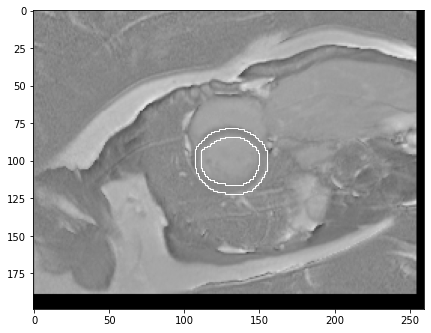

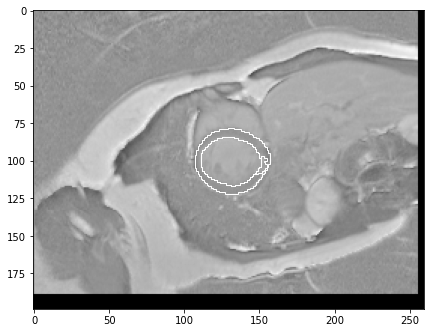

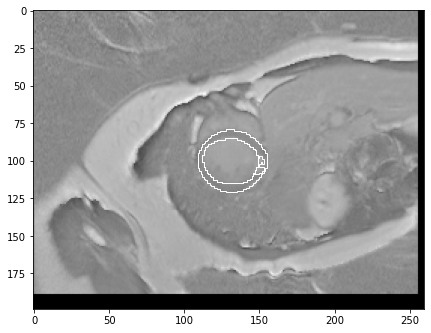

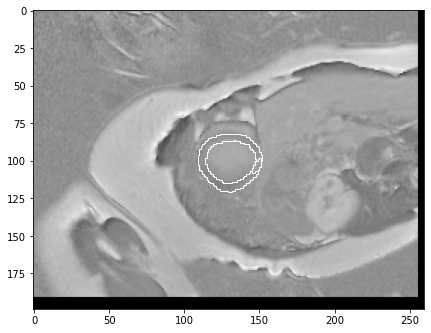

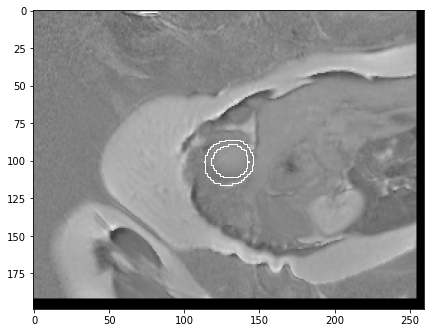

In [11]:
cases = [pickle.load(open(os.path.join(bp_cases,p), 'rb')) for p in os.listdir(bp_cases)]
v     = SAX_LGE_View()
cases = [v.customize_case(c) for c in cases]
case  = cases[50] # 50th is the first patient -with- scars
cat   = case.categories[0]
print(case.case_name)
for cr in case.crs: 
    print(cr.name, cr.get_cr(), cr.unit)
for d in range(cat.nr_slices):
    img, anno = cat.get_img(d,0), cat.get_anno(d,0)
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    ax.imshow(img, cmap='gray')
    anno.plot_all_contour_outlines(ax)
    plt.show()